In [1]:
import sys
import time
import torch
from numpy import linspace as linspace
import numpy.linalg as la
import numpy as np
import importlib
import itertools
import nimfa

from matplotlib import pyplot as plt

from grad_attacks import *

In [2]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [3]:
# Generate synthetic data
np.random.seed(seed=702)
H = np.random.rand(3,200)
Winit = np.random.rand(103,3)
Hinit = np.random.rand(3,200)
Winit = torch.Tensor(Winit)
Hinit = torch.Tensor(Hinit)
x=np.arange(0,103)
Worig=np.zeros((103,3))
w1 = gaussian(x, 30, 10)
w1=w1/np.max(w1) #la.norm(w1)
w2 = gaussian(x,70,10)
w2=w2/np.max(w2)  #la.norm(w2)
w3 = w1+w2*.10
w3=w3/np.max(w1)  #la.norm(w3)
Worig[:,0] = w1
Worig[:,1] = w2
Worig[:,2] = w3
Worig[100,0]=1.0
Worig[101,1]=1.0
Worig[102,2]=1.0

Xorig = Worig@H

Wpert = np.zeros_like(Worig)
Wpert[100,0]=1.0
Wpert[101,1]=1.0
Wpert[102,2]=1.0
Xerr1=-1*Wpert@H
Xpert=Xorig+Xerr1

In [4]:
XorigT = Tcons(Xorig,device).float()
XpertT = Tcons(Xpert,device).float()
WinitT = Tcons(Winit,device).float()
HinitT = Tcons(Hinit,device).float()

Wstay,Hstay = NMFiter_KL(XorigT,10000,WinitT,HinitT)

In [5]:
# Perform 100 more iteration with base
Wba,Hba = NMFiter_KL(XorigT,100,Wstay,Hstay)
X0 = Wstay@Hstay
Xba = Wba@Hba
print(torch.max(torch.abs(X0-Xba)))
print(torch.max(torch.abs(Wba-Wstay)))
print(torch.max(torch.abs(Hba-Hstay)))

tensor(2.8908e-05, device='cuda:0')
tensor(7.2986e-05, device='cuda:0')
tensor(2.0295e-05, device='cuda:0')


In [6]:
# NMF on perturbation matrix
Wpertstay,Hpertstay = NMFiter_KL(XpertT,10000,WinitT,HinitT)
# Perform 100 more iteration with base of perturbed X
Wpertba,Hpertba = NMFiter_KL(XpertT,100,Wpertstay,Hpertstay)
Xpert0 = Wpertstay@Hpertstay
Xpertba = Wpertba@Hpertba
print(torch.max(torch.abs(Xpert0-Xpertba)))
print(torch.max(torch.abs(Wpertba-Wpertstay)))
print(torch.max(torch.abs(Hpertba-Hpertstay)))

tensor(5.9605e-07, device='cuda:0')
tensor(9.8944e-06, device='cuda:0')
tensor(0.0001, device='cuda:0')


In [7]:
print("** Base information **")
print("-- FE error: ", loss_wh(Tcons(Worig,device),Wstay,Tcons(H,device),Hstay).cpu().detach().numpy())
print("-- Recon error: ", (torch.norm(XorigT - X0)/torch.norm(XorigT)).cpu().detach().numpy())

print("** Perturbation information **")
print("-- FE error: ", loss_wh(Tcons(Worig,device),Wpertstay,Tcons(H,device),Hpertstay).cpu().detach().numpy())
print("-- Recon error: ", (torch.norm(XorigT - Xpert0)/torch.norm(XorigT)).cpu().detach().numpy())
print("-- Noise rlt norm: ", (torch.norm(XpertT - XorigT)/torch.norm(XorigT)).cpu().detach().numpy())

** Base information **
-- FE error:  0.042924695
-- Recon error:  0.0012353921
** Perturbation information **
-- FE error:  0.3969566
-- Recon error:  0.18646169
-- Noise rlt norm:  0.18646675


/vast/home/mvu/NMF_attacks/grad_attacks.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  HorigB = (Horig.T*(tNormOrig/torch.norm(Horig,dim=1).T.unsqueeze(0))).T


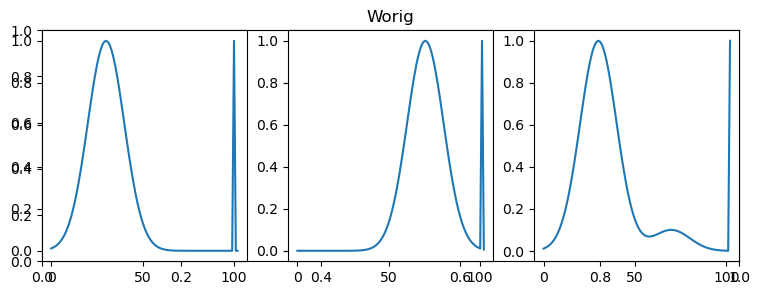

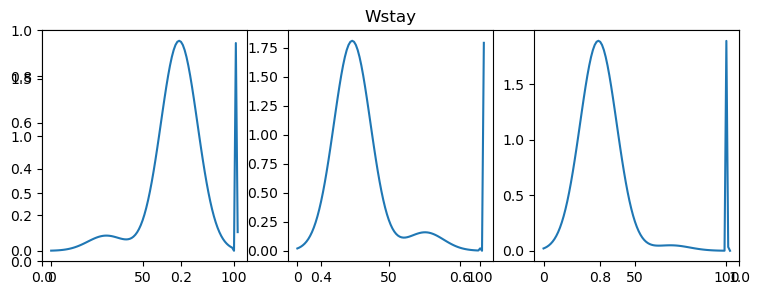

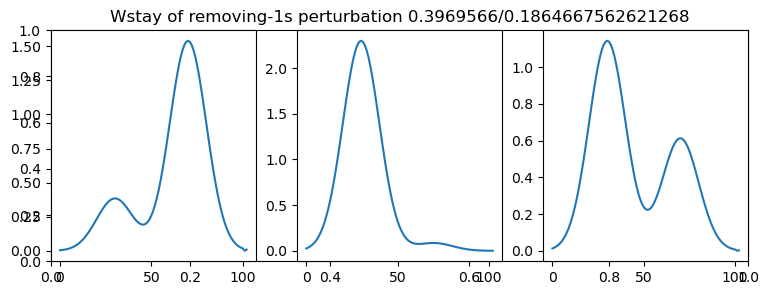

In [8]:
# Some visualizations
plt.figure(figsize=(9,3))
plt.title("Worig")
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(Worig[:,i])

plt.figure(figsize=(9,3))
plt.title("Wstay")
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(Wstay.detach().cpu().numpy()[:,i])
# plt.figure()

plt.figure(figsize=(9,3))
out_err = loss_wh(Tcons(Worig,device),Wpertstay,Tcons(H,device),Hpertstay).cpu().detach().numpy()
in_err = np.linalg.norm(Xerr1)/np.linalg.norm(Xorig)
# in_err = in_err.cpu().detach().numpy()

plt.title("Wstay of removing-1s perturbation " + str(out_err) + "/" + str(in_err))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(Wpertstay.detach().cpu().numpy()[:,i])
# plt.figure()

# Question 1: Is NMF vulnerable to FE attack?

In [9]:
# Naive direction along the 1s component of W:
noise_direction = (XpertT - XorigT)

min_factor = 0
max_factor = 1.4
no_eps = 14

factor_range = max_factor - min_factor
max_clip = torch.max(XorigT)

in_X_dists = []
out_X_dists = []
out_FE_dists = []
noise_factors = []

for step in range(no_eps):
    noise_factor = step/no_eps * (factor_range) + min_factor
    noise_factors.append(noise_factor)

    Xperturb = XorigT + noise_factor * noise_direction
    Xperturb = torch.clip(Xperturb, min = 0)
    in_X_dist = (torch.norm(Xperturb - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    in_X_dists.append(in_X_dist)

    Wp,Hp = NMFiter_KL(Xperturb,10000,WinitT,HinitT)
    out_X_dist = (torch.norm(Wp@Hp - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    out_X_dists.append(out_X_dist)

    out_FE_dist = loss_wh(Wstay,Wp,Hstay,Hp).cpu().detach().numpy()
    out_FE_dists.append(out_FE_dist)

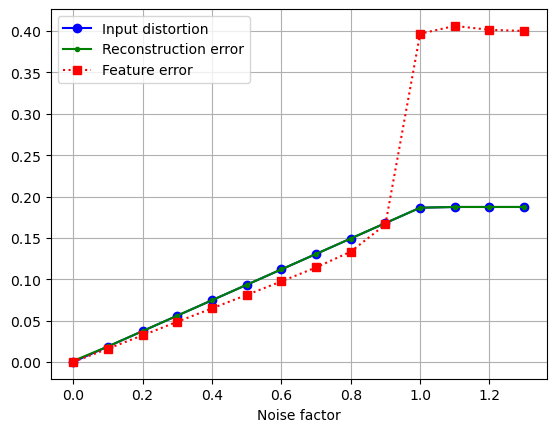

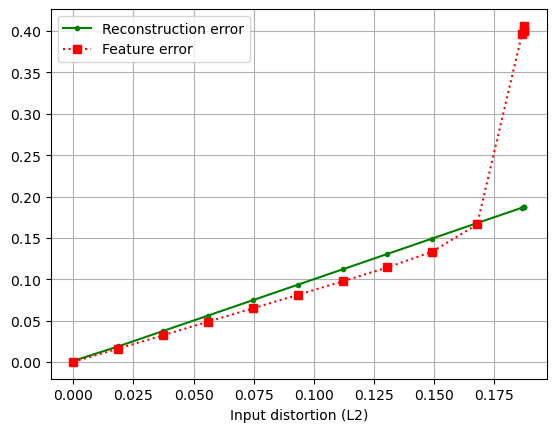

In [10]:
plt.figure()
plt.plot(noise_factors, in_X_dists, 'bo-', label = 'Input distortion')
plt.plot(noise_factors, out_X_dists, 'g.-', label = 'Reconstruction error')
plt.plot(noise_factors, out_FE_dists, 'rs:', label = 'Feature error')
plt.xlabel("Noise factor")
plt.legend()
plt.grid()

plt.figure()
plt.plot(in_X_dists, out_X_dists, 'g.-', label = 'Reconstruction error')
plt.plot(in_X_dists, out_FE_dists, 'rs:', label = 'Feature error')
plt.xlabel("Input distortion (L2)")
plt.legend()
plt.grid()

# Question 2: Can we have better methods to damage the FE error?

## Back-propagate method

In [11]:
# Back-propagate method
attacker_back = Gradient_based_attack(XorigT, 
                 nmf_rank = 3, 
                 base_nmf_iters = 2000,  
                 use_cuda = True,
                 implicit_func = False,
                 taylor = 100,
                 norm = "Linf", 
                 rec_loss = False,
                 verbose = True)

Xdim:  20600
Wdim:  309
Hdim:  600
NMF iteration:  2000
NMF rank:  3
Gradient type:  Back-propagate
NMF stationary (W,H) error:  (tensor(8.5065e-05, device='cuda:0'), tensor(8.8999e-05, device='cuda:0'))


In [12]:
torch.cuda.reset_peak_memory_stats()
print(torch.cuda.max_memory_reserved())
print(torch.cuda.max_memory_allocated())
print(torch.cuda.max_memory_cached())

23068672
9209856
23068672


/vast/home/mvu/.conda/envs/minhvu121/lib/python3.12/site-packages/torch/cuda/memory.py:449: FutureWarning: torch.cuda.max_memory_cached has been renamed to torch.cuda.max_memory_reserved
  warnings.warn(


In [13]:
# torch.cuda.memory_stats()

In [14]:
min_eps = 0
max_eps = 0.16
no_eps = 16

factor_range = max_eps - min_eps
max_clip = torch.max(XorigT)

in_X_dists_back_pgd = []
out_X_dists_back_pgd = []
out_FE_dists_back_pgd = []
eps_linf = []

for step in range(no_eps):
    # torch.cuda.reset_peak_memory_stats()
    # start_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.allocated'] - torch.cuda.memory_stats()['active_bytes.all.freed']
    eps = step/no_eps * (factor_range) + min_eps
    eps_linf.append(eps)
    print("Generate attack for eps = ", eps)

    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    start_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.peak'] #torch.cuda.memory_stats()['active_bytes.all.allocated'] # - torch.cuda.memory_stats()['active_bytes.all.freed']
    Xperturb = attacker_back.pgd_attack(eps=eps, alpha=1, iters=40, record = False, average_grad = 1)
    end_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.peak'] # - torch.cuda.memory_stats()['active_bytes.all.freed']
    duration = time.time()-start_time
    
    in_X_dist = (torch.norm(Xperturb - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    in_X_dists_back_pgd.append(in_X_dist)

    Wp,Hp = NMFiter_KL(Xperturb,10000,WinitT,HinitT)
    out_X_dist = (torch.norm(Wp@Hp - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    out_X_dists_back_pgd.append(out_X_dist)

    out_FE_dist = loss_wh(Wstay,Wp,Hstay,Hp).cpu().detach().numpy()
    out_FE_dists_back_pgd.append(out_FE_dist)
    # end_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.allocated'] - torch.cuda.memory_stats()['active_bytes.all.freed']

    # duration = time.time()-start_time
    memory = end_mem_allocated
    memory_Mb = memory/1000000
    
    print("Input distortion: ", in_X_dist)
    print("FE distortion: ", out_FE_dist)
    print("Duration (sec): ", duration)
    print("Memory (Mb): ", memory_Mb)
    print("----")

Generate attack for eps =  0.0
Input distortion:  0.0
FE distortion:  0.0
Duration (sec):  125.27329564094543
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.01
Input distortion:  0.01919331
FE distortion:  0.13150522
Duration (sec):  122.66683173179626
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.02
Input distortion:  0.03805683
FE distortion:  0.1730603
Duration (sec):  119.85499548912048
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.03
Input distortion:  0.05684409
FE distortion:  0.30579144
Duration (sec):  110.52422499656677
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.04
Input distortion:  0.07504085
FE distortion:  0.45362324
Duration (sec):  99.60078263282776
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.05
Input distortion:  0.09337125
FE distortion:  0.46572837
Duration (sec):  99.62389039993286
Memory (Mb):  1045.207552
----
Generate attack for eps =  0.06
Input distortion:  0.11184466
FE distortion:  0.57

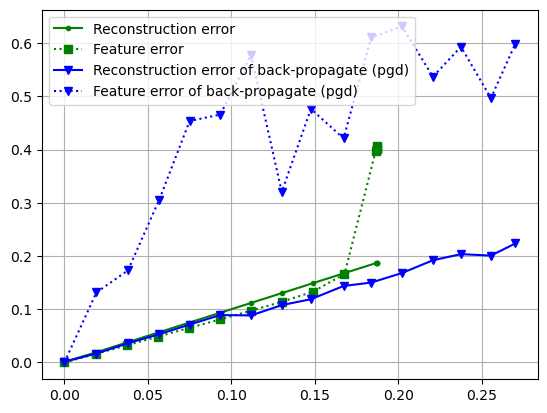

In [15]:
plt.figure()
plt.plot(in_X_dists, out_X_dists, 'g.-', label = 'Reconstruction error')
plt.plot(in_X_dists, out_FE_dists, 'gs:', label = 'Feature error')
plt.plot(in_X_dists_back_pgd, out_X_dists_back_pgd, 'bv-', label = 'Reconstruction error of back-propagate (pgd)')
plt.plot(in_X_dists_back_pgd, out_FE_dists_back_pgd, 'bv:', label = 'Feature error of back-propagate (pgd)')
plt.legend()
plt.grid()

## Implicit method

In [16]:
# Implicit method
attacker_implicit = Gradient_based_attack(XorigT, 
                 nmf_rank = 3, 
                 base_nmf_iters = 2000,  
                 use_cuda = True,
                 implicit_func = True,
                 taylor = 120,
                 norm = "Linf", 
                 rec_loss = False,
                 verbose = True)

Xdim:  20600
Wdim:  309
Hdim:  600
NMF iteration:  2000
NMF rank:  3
Gradient type:  Implicit function
NMF stationary (W,H) error:  (tensor(0.0001, device='cuda:0'), tensor(0.0001, device='cuda:0'))


In [17]:
min_eps = 0
max_eps = 0.16
no_eps = 16
# min_eps = 0.02
# max_eps = 0.16
# no_eps = 2

factor_range = max_eps - min_eps
max_clip = torch.max(XorigT)

in_X_dists_ifunc_pgd = []
out_X_dists_ifunc_pgd = []
out_FE_dists_ifunc_pgd = []
eps_linf = []

for step in range(no_eps):
    eps = step/no_eps * (factor_range) + min_eps
    eps_linf.append(eps)
    print("Generate attack for eps = ", eps)

    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    start_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.peak']
    Xperturb = attacker_implicit.pgd_attack(eps=eps, alpha=1, iters=40, record = False, average_grad = 1)
    end_mem_allocated = torch.cuda.memory_stats()['active_bytes.all.peak'] # - torch.cuda.memory_stats()['active_bytes.all.freed']
    duration = time.time()-start_time

    in_X_dist = (torch.norm(Xperturb - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    in_X_dists_ifunc_pgd.append(in_X_dist)

    Wp,Hp = NMFiter_KL(Xperturb,10000,WinitT,HinitT)
    out_X_dist = (torch.norm(Wp@Hp - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    out_X_dists_ifunc_pgd.append(out_X_dist)

    out_FE_dist = loss_wh(Wstay,Wp,Hstay,Hp).cpu().detach().numpy()
    out_FE_dists_ifunc_pgd.append(out_FE_dist)
    print("Duration: ", time.time() - start_time)

    # duration = time.time()-start_time
    memory = end_mem_allocated
    memory_Mb_ifunc = memory/1000000
    
    print("Input distortion: ", in_X_dist)
    print("FE distortion: ", out_FE_dist)
    print("Duration (sec): ", duration)
    print("Memory (Mb): ", memory_Mb_ifunc)
    print("----")

Generate attack for eps =  0.0
Duration:  61.367167949676514
Input distortion:  0.0
FE distortion:  0.0
Duration (sec):  58.06835389137268
Memory (Mb):  262.46912
----
Generate attack for eps =  0.01
Duration:  61.691465616226196
Input distortion:  0.01923763
FE distortion:  0.16032492
Duration (sec):  58.32758355140686
Memory (Mb):  262.46912
----
Generate attack for eps =  0.02
Duration:  64.52016639709473
Input distortion:  0.038208622
FE distortion:  0.09955316
Duration (sec):  61.12525010108948
Memory (Mb):  262.46912
----
Generate attack for eps =  0.03
Duration:  69.17360186576843
Input distortion:  0.05678034
FE distortion:  0.47179258
Duration (sec):  65.86189913749695
Memory (Mb):  262.46912
----
Generate attack for eps =  0.04
Taylor's order:  109
Duration:  59.69999885559082
Input distortion:  0.07451895
FE distortion:  0.6155308
Duration (sec):  56.408732414245605
Memory (Mb):  262.46912
----
Generate attack for eps =  0.05
Taylor's order:  109
Taylor's order:  99
Taylor's

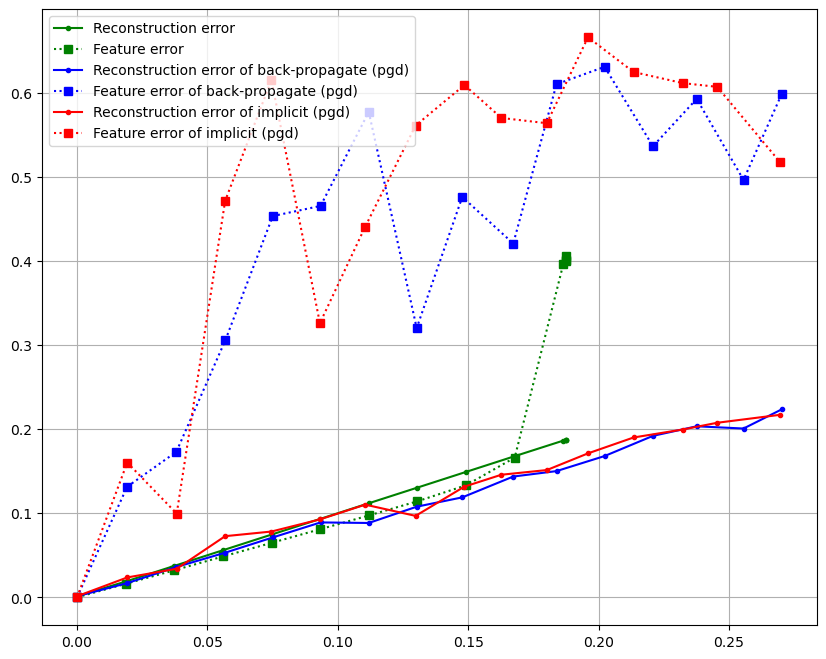

In [18]:
plt.figure(figsize = (10,8))
plt.plot(in_X_dists, out_X_dists, 'g.-', label = 'Reconstruction error')
plt.plot(in_X_dists, out_FE_dists, 'gs:', label = 'Feature error')
plt.plot(in_X_dists_back_pgd, out_X_dists_back_pgd, 'b.-', label = 'Reconstruction error of back-propagate (pgd)')
plt.plot(in_X_dists_back_pgd, out_FE_dists_back_pgd, 'bs:', label = 'Feature error of back-propagate (pgd)')
plt.plot(in_X_dists_ifunc_pgd, out_X_dists_ifunc_pgd, 'r.-', label = 'Reconstruction error of implicit (pgd)')
plt.plot(in_X_dists_ifunc_pgd, out_FE_dists_ifunc_pgd, 'rs:', label = 'Feature error of implicit (pgd)')
plt.legend()
plt.grid()

# Question 3: What if we optimize with recon loss?

In [19]:
# Back-propagate method with recon loss
attacker = Gradient_based_attack(XorigT, 
                 nmf_rank = 3, 
                 base_nmf_iters = 2000,  
                 use_cuda = True,
                 implicit_func = False,
                 taylor = 100,
                 norm = "Linf", 
                 rec_loss = True,
                 verbose = True)

Xdim:  20600
Wdim:  309
Hdim:  600
NMF iteration:  2000
NMF rank:  3
Gradient type:  Back-propagate
NMF stationary (W,H) error:  (tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'))


In [20]:
min_eps = 0
max_eps = 0.16
no_eps = 16

factor_range = max_eps - min_eps
max_clip = torch.max(XorigT)

in_X_dists_back_pgd_rec_loss = []
out_X_dists_back_pgd_rec_loss = []
out_FE_dists_back_pgd_rec_loss = []
eps_linf = []

for step in range(no_eps):
    eps = step/no_eps * (factor_range) + min_eps
    eps_linf.append(eps)
    print("Generate attack for eps = ", eps)

    start_time = time.time()

    Xperturb = attacker.pgd_attack(eps=eps, alpha=1, iters=40, record = False, average_grad = 1)
    in_X_dist = (torch.norm(Xperturb - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    in_X_dists_back_pgd_rec_loss.append(in_X_dist)

    Wp,Hp = NMFiter_KL(Xperturb,10000,WinitT,HinitT)
    out_X_dist = (torch.norm(Wp@Hp - XorigT)/torch.norm(XorigT)).cpu().detach().numpy()
    out_X_dists_back_pgd_rec_loss.append(out_X_dist)

    out_FE_dist = loss_wh(Wstay,Wp,Hstay,Hp).cpu().detach().numpy()
    out_FE_dists_back_pgd_rec_loss.append(out_FE_dist)
    print("Input distortion: ", in_X_dist)
    print("FE distortion: ", out_FE_dist)
    print("Duration: ", time.time() - start_time)
    print("----")

Generate attack for eps =  0.0
Input distortion:  0.0
FE distortion:  0.0
Duration:  102.29898500442505
----
Generate attack for eps =  0.01
Input distortion:  0.019209446
FE distortion:  0.07968932
Duration:  102.18258380889893
----
Generate attack for eps =  0.02
Input distortion:  0.038223755
FE distortion:  0.3488514
Duration:  102.05002093315125
----
Generate attack for eps =  0.03
Input distortion:  0.05694836
FE distortion:  0.17748345
Duration:  101.98292326927185
----
Generate attack for eps =  0.04
Input distortion:  0.07616106
FE distortion:  0.3508832
Duration:  102.01270627975464
----
Generate attack for eps =  0.05
Input distortion:  0.09485134
FE distortion:  0.39056003
Duration:  102.01019811630249
----
Generate attack for eps =  0.06
Input distortion:  0.1127044
FE distortion:  0.6104674
Duration:  102.01164269447327
----
Generate attack for eps =  0.07
Input distortion:  0.13094617
FE distortion:  0.62122005
Duration:  101.93278193473816
----
Generate attack for eps =

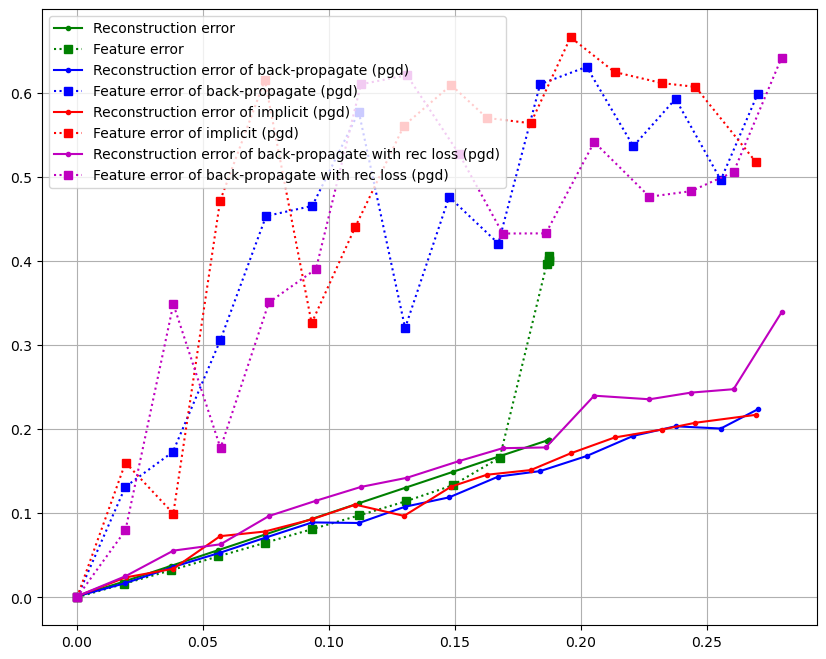

In [21]:
plt.figure(figsize = (10,8))
plt.plot(in_X_dists, out_X_dists, 'g.-', label = 'Reconstruction error')
plt.plot(in_X_dists, out_FE_dists, 'gs:', label = 'Feature error')
plt.plot(in_X_dists_back_pgd, out_X_dists_back_pgd, 'b.-', label = 'Reconstruction error of back-propagate (pgd)')
plt.plot(in_X_dists_back_pgd, out_FE_dists_back_pgd, 'bs:', label = 'Feature error of back-propagate (pgd)')
plt.plot(in_X_dists_ifunc_pgd, out_X_dists_ifunc_pgd, 'r.-', label = 'Reconstruction error of implicit (pgd)')
plt.plot(in_X_dists_ifunc_pgd, out_FE_dists_ifunc_pgd, 'rs:', label = 'Feature error of implicit (pgd)')
plt.plot(in_X_dists_back_pgd_rec_loss, out_X_dists_back_pgd_rec_loss, 'm.-', label = 'Reconstruction error of back-propagate with rec loss (pgd)')
plt.plot(in_X_dists_back_pgd_rec_loss, out_FE_dists_back_pgd_rec_loss, 'ms:', label = 'Feature error of back-propagate with rec loss (pgd)')
plt.legend()
plt.grid()